# Baseline Model — Logistic Regression

**Goal:** Create a strong baseline with clean preprocessing, well-structured pipelines, and stratified CV.<br>
**Model:** Logistic Regression (Linear baseline, interpretable) with Class Weights.<br>
**Metrics:** Accuracy, ROC-AUC.

# 1. -  4.  Getting Ready 😺

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 1. Load Data
print("🤖Loading data...")
train = pd.read_csv("../../train.csv", low_memory=False)
test = pd.read_csv("../../test.csv", low_memory=False)

# 2. Drop rows with missing target
print("Cleaning target...")
train = train.dropna(subset=['Credit_Score'])

# 3. Define Features
# Drop ID-like and high-cardinality columns so we ignore them for now
drop_cols = ['ID', 'Customer_ID', 'Name', 'SSN', 'Credit_Score']

# Helper function we use to clean numeric columns that are stored as messy strings
def clean_numeric(x):
    if isinstance(x, str):
        x = x.replace('_', '').replace(',', '').strip()
        if x == '':
            return np.nan
        return float(x)
    return x

# Numeric columns that might be strings
num_cols_to_clean = ['Age', 'Annual_Income', 'Outstanding_Debt', 'Num_of_Delayed_Payment', 'Num_of_Loan', 
                     'Amount_invested_monthly', 'Monthly_Balance', 'Changed_Credit_Limit']
for col in num_cols_to_clean:
    print(f"🧹Cleaning column: {col}")
    train[col] = train[col].apply(clean_numeric)
    test[col] = test[col].apply(clean_numeric)

# Beforehand we have seen "Credit_History_Age" is structured as (e.g., "22 Years 5 Months")
# Credit_History_Age parsing
def parse_credit_history_age(x):
    if pd.isna(x): return np.nan
    try:
        parts = x.split(' ')
        years = int(parts[0])
        months = int(parts[3])
        return years * 12 + months
    except:
        return np.nan

train['Credit_History_Age'] = train['Credit_History_Age'].apply(parse_credit_history_age)
test['Credit_History_Age'] = test['Credit_History_Age'].apply(parse_credit_history_age)

# 4. Prepare Features and Target
print("Preparing features and target🎯...")
# Define X and y
X = train.drop(columns=drop_cols)
y = train['Credit_Score']


🤖Loading data...
Cleaning target...
🧹Cleaning column: Age
🧹Cleaning column: Annual_Income
🧹Cleaning column: Outstanding_Debt
🧹Cleaning column: Num_of_Delayed_Payment
🧹Cleaning column: Num_of_Loan
🧹Cleaning column: Amount_invested_monthly
🧹Cleaning column: Monthly_Balance
🧹Cleaning column: Changed_Credit_Limit
Preparing features and target🎯...


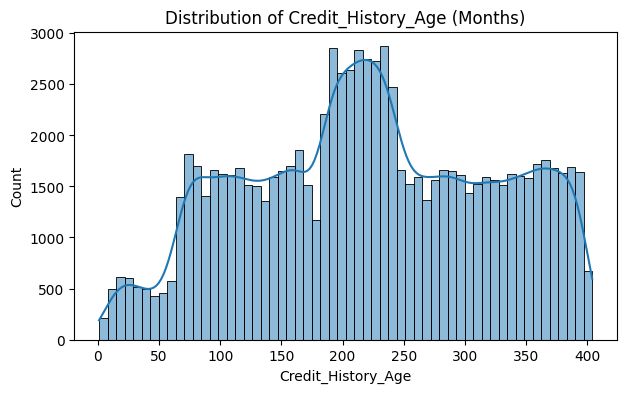

In [2]:
#verify parsing worked on the Credit_History_Age column
plt.figure(figsize=(7,4))
sns.histplot(train['Credit_History_Age'], kde=True)
plt.title("Distribution of Credit_History_Age (Months)")
plt.show()


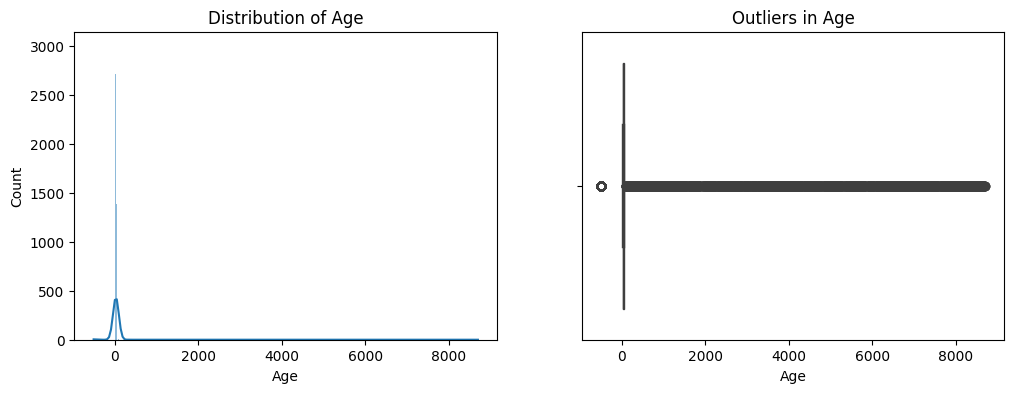

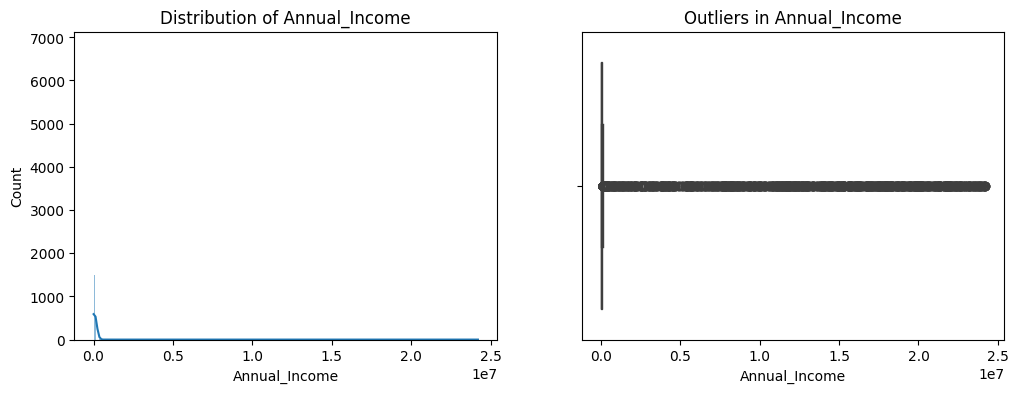

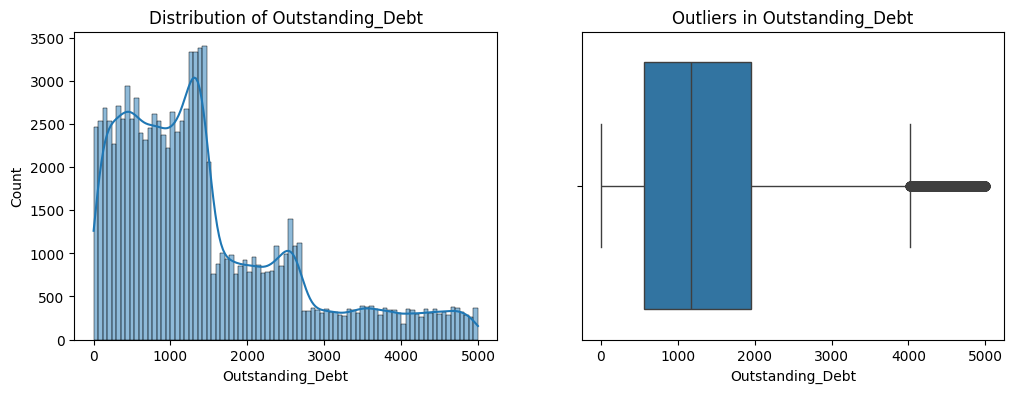

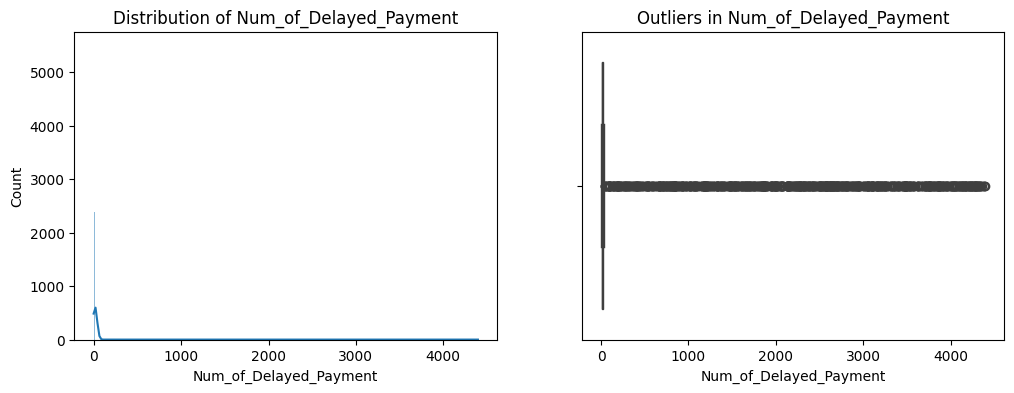

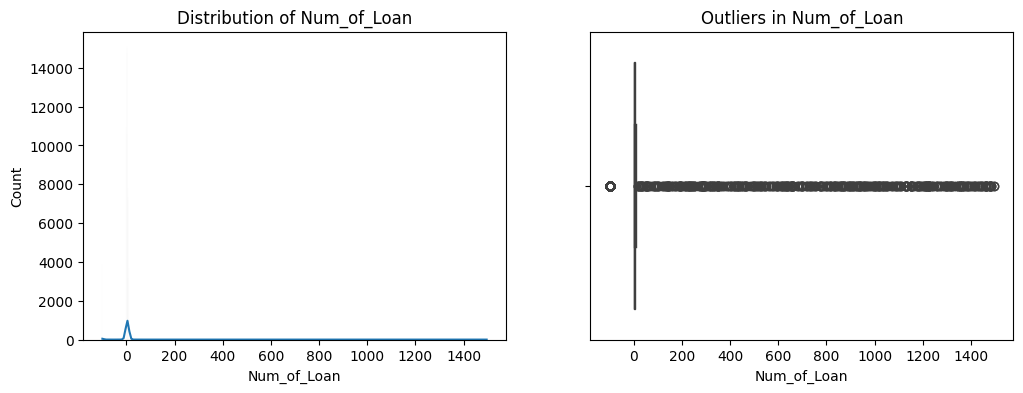

In [3]:
num_preview = ['Age', 'Annual_Income', 'Outstanding_Debt', 
               'Num_of_Delayed_Payment', 'Num_of_Loan']

for col in num_preview:
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    
    sns.histplot(train[col], kde=True, ax=ax[0])
    ax[0].set_title(f"Distribution of {col}")
    
    sns.boxplot(x=train[col], ax=ax[1])
    ax[1].set_title(f"Outliers in {col}")
    
    plt.show()


In [4]:

# Target Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Target Mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Select columns for pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"🔢 Numeric Features: {len(numeric_features)}")
print(f"🔤Categorical Features: {len(categorical_features)}")

Target Mapping: {'Good': 0, 'Poor': 1, 'Standard': 2}
🔢 Numeric Features: 17
🔤Categorical Features: 6


# 5.Build Preprocessing Pipeline
#               & 
# 6. Build Model Pipeline

In [5]:
# 5.Build Preprocessing Pipeline
# Numeric Transformer
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformer
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessor
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# 6. Build Model Pipeline
base_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1907)

# Full Pipeline
full_pipeline = Pipeline(steps=[('prep', preprocess),
                      ('logreg', base_model)])

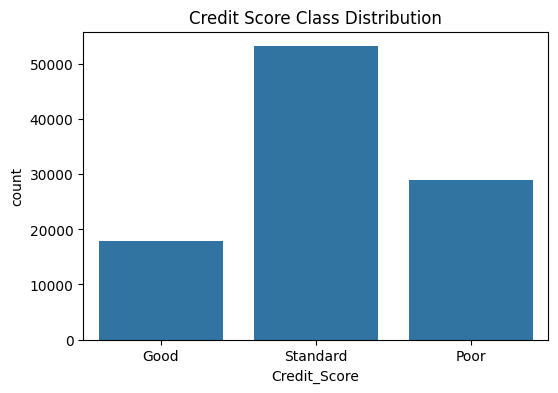

In [6]:
#Before proceeding to stratified k-fold cross-validation, let's visualize some of the columns relationship with the target variable.
#Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Credit Score Class Distribution")
plt.show()


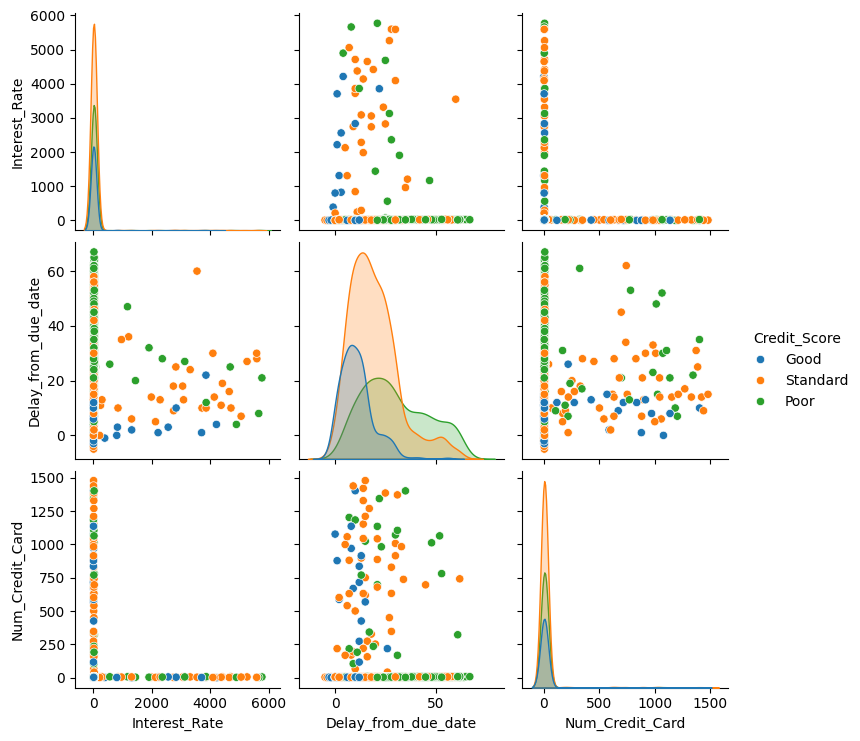

In [7]:
# Pairplot (gonna use a sample due to the size of the dataset otherwise it will be too heavy)
important_cols = [
    'Interest_Rate', 
    'Delay_from_due_date', 
    'Num_Credit_Card',
    'Credit_Score'
]

sns.pairplot(train[important_cols].sample(3000, random_state=42), 
             hue='Credit_Score',
             hue_order=['Good','Standard','Poor'])
plt.show()


# 7. Stratified K-Fold CV

In [8]:

print("\n🔄 Running Stratified K-Fold CV (5 Splits)...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1907)

accuracies = []
roc_aucs = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y_encoded)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]
    
    full_pipeline.fit(X_train_fold, y_train_fold)
    y_pred = full_pipeline.predict(X_val_fold)
    y_prob = full_pipeline.predict_proba(X_val_fold)
    
    acc = accuracy_score(y_val_fold, y_pred)
    try:
        auc = roc_auc_score(y_val_fold, y_prob, multi_class='ovr')
    except:
        auc = 0.0
        
    accuracies.append(acc)
    roc_aucs.append(auc)
    
    print(f"➤ Fold {fold+1} - Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}")

print("\n📊 Final Results ")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
print(f"Mean ROC-AUC: {np.mean(roc_aucs):.4f}")


🔄 Running Stratified K-Fold CV (5 Splits)...
➤ Fold 1 - Accuracy: 0.7233, ROC-AUC: 0.8666
➤ Fold 2 - Accuracy: 0.7239, ROC-AUC: 0.8645
➤ Fold 3 - Accuracy: 0.7183, ROC-AUC: 0.8645
➤ Fold 4 - Accuracy: 0.7204, ROC-AUC: 0.8638
➤ Fold 5 - Accuracy: 0.7210, ROC-AUC: 0.8651

📊 Final Results 
Mean Accuracy: 0.7214 (+/- 0.0020)
Mean ROC-AUC: 0.8649


# 8. Train Final Model on Full Data

In [9]:

full_pipeline.fit(X, y_encoded)
print("\n✅ Final Baseline Model Trained on Full Data✨")


✅ Final Baseline Model Trained on Full Data✨


## 9. Baseline Results & Interpretation

Performance:

Accuracy: ~72%

ROC-AUC: ~0.86

Interpretation:
Logistic Regression gives a reasonable starting point, but the performance indicates that the relationship between features and credit score is likely non-linear. A tree-based or ensemble model (RF, XGBoost, LightGBM) will almost certainly capture more complex patterns.